# Part 1

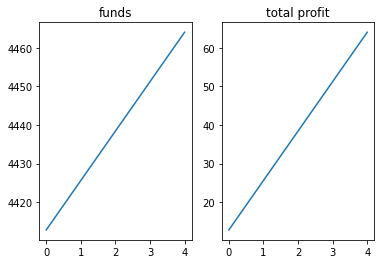

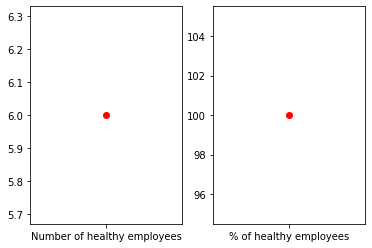

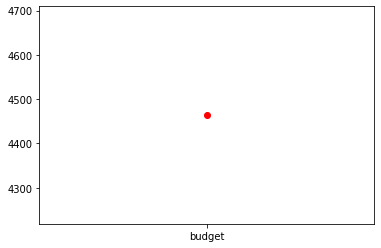

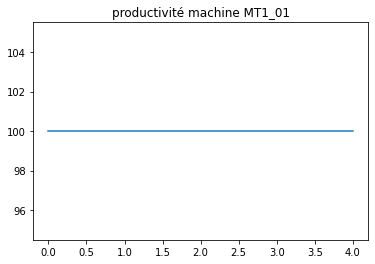

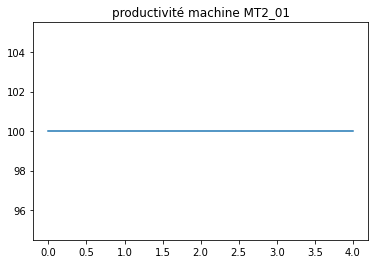

<Figure size 432x288 with 0 Axes>

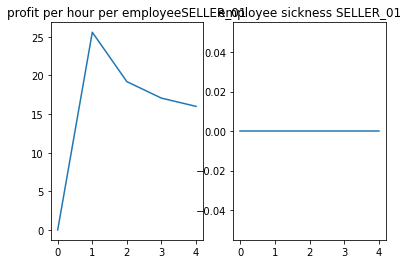

<Figure size 432x288 with 0 Axes>

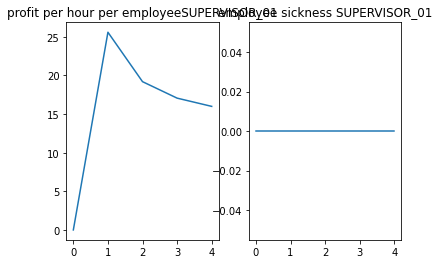

<Figure size 432x288 with 0 Axes>

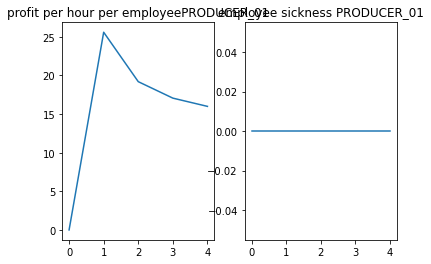

<Figure size 432x288 with 0 Axes>

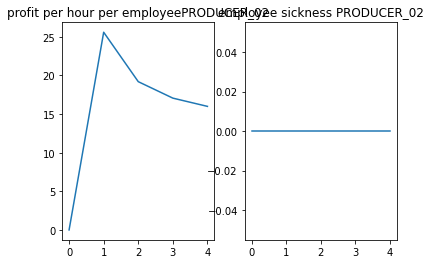

<Figure size 432x288 with 0 Axes>

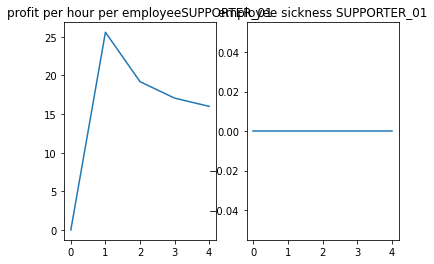

<Figure size 432x288 with 0 Axes>

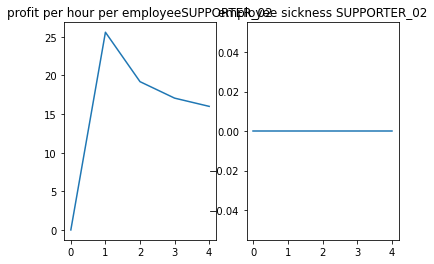

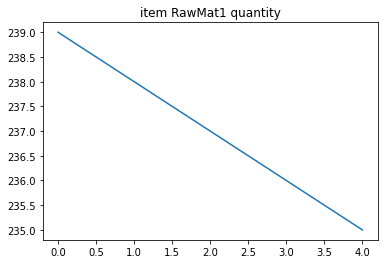

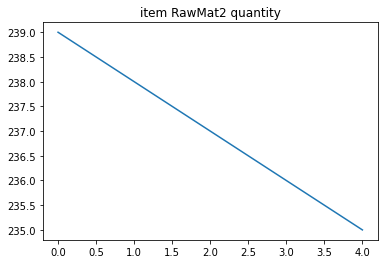

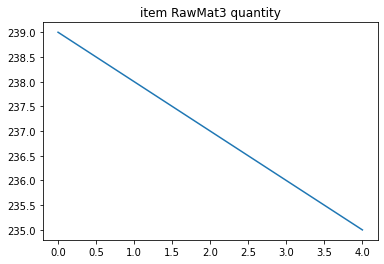

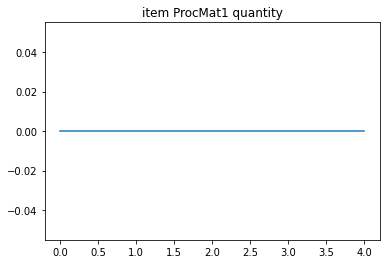

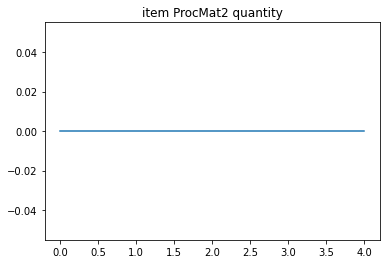

In [11]:
PORT = 8000

import requests

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


# Make a request to create a new simulation
def init():
    url = f'http://127.0.0.1:{PORT}/control/poll/create_from_example_sim4/{"T3"}'
    response = requests.post(url)
    if response.status_code == requests.codes.ok:
        jresponse = response.json()
        

# Make a request to run one step
def next_step():
    url = f'http://127.0.0.1:{PORT}/control/poll/run_one_step'
    response = requests.post(url)
    if response.status_code == requests.codes.ok:
        jresponse = response.json()
        print(f"Next Step")

# Make a request to get the current funds available
def get_next_point():
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/inventory'
    response = requests.get(url)
    if response.status_code == requests.codes.ok:
        jresponse = response.json()
        print(f"Funds : {jresponse['funds_in_eur']}")
        return jresponse['funds_in_eur']
    else:
        return None

# Make a request to get the status of every machine
def get_status_machines():
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/machine'
    response = requests.get(url)
    jresponse = response.json()
    machines = []

    for i in range (len(jresponse)):
        machines.append((jresponse[i]['name'],jresponse[i]['operating_efficiency_percentage']))
    return machines

#Make a request to get the health of every employee
def get_employee_health():
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/employee'
    response = requests.get(url)
    jresponse = response.json()
    employee = []
    for i in range (len(jresponse)):
        employee.append((jresponse[i]['name'],jresponse[i]['remaining_sickness_in_hours_worked']))
    return employee

#Make a request to get contents of inventory per type of item
def get_inventory():
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/inventory'
    response = requests.get(url)
    jresponse = response.json()
    item_quantities = []
    for i in range (len(jresponse['item_quantities'])):
        item_quantities.append((jresponse['item_quantities'][i]['item']['name'],jresponse['item_quantities'][i]['quantity']))
    return item_quantities

def time_snapshot_budget():
    url=f'http://127.0.0.1:{PORT}/enterprise/poll/inventory'
    response = requests.get(url)
    budget = response.json()["funds_in_eur"]
    plt.figure()
    plt.plot("budget",budget,"ro")
    plt.show()

def time_snapshot_health():
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/employee'
    response = requests.get(url)
    number_of_healthy=0
    for employee in response.json():
        if employee['remaining_sickness_in_hours_worked'] == 0:
            number_of_healthy+=1
    plt.figure()
    plt.subplot(121)
    plt.plot("Number of healthy employees",number_of_healthy,"ro")
    plt.subplot(122)
    plt.plot("% of healthy employees", (number_of_healthy/len(response.json())*100),"ro")
    plt.show()

# List holding the x values
data_x = []
# List holding the y values
data_y = []
# List holding the machine status
machines = []
# List holding the employee status
employees = []
# List holding item quantities
item_quantities = []
#List holding profits
profits = []
# Create sim
init()
#Initial funds
url = f'http://127.0.0.1:{PORT}/enterprise/poll/inventory'
response = requests.get(url)
jresponse = response.json()
initial_funds=jresponse['funds_in_eur']
#Dict holding working hours per employee
working_hours={}
url = f'http://127.0.0.1:{PORT}/enterprise/poll/employee'
response = requests.get(url)
jresponse = response.json()
for i in range (len(jresponse)):
    working_hours[jresponse[i]['name']] = [0]
    


for x in range(0, 5):
    next_step() # Do one step
    y = get_next_point() # Request a new random value and store in y
    m = get_status_machines()
    e = get_employee_health()
    it = get_inventory()
    machines.append(m)
    employees.append(e)
    item_quantities.append(it)
    profits.append(y-initial_funds)
    data_x.append(x)  # Add the current x to the list
    data_y.append(y) # Add the current y to the list
    clear_output(wait=True) # Clear / remove whatever was already plotted before
    plt.figure()
    plt.subplot(121)
    plt.plot(data_x, data_y)
    plt.title("funds")# Re-plot the data with the new added values in the list
    plt.subplot(122) #Composite plot
    plt.plot(data_x, profits)
    plt.title("total profit")
    time_snapshot_health()
    time_snapshot_budget()
    for i in range (len(m)): #Plot machine status
        plt.figure()
        data = []
        for j in range (len(machines)):
            data.append(machines[j][i][1])
        plt.plot(data_x,data)
        plt.title("productivité machine "+m[i][0])
    for i in range (len(e)): #Plot employee health+profit per hour per employee
        plt.figure()
        data=[]
        pphpe=[]
        if e[i][1] == 0 : #Add one hour of work if not sick
            working_hours[e[i][0]].append(working_hours[e[i][0]][-1]+1)
        else :
            working_hours[e[i][0]].append(working_hours[e[i][0]][-1])
        for j in range (len(employees)):
            data.append(employees[j][i][1])
            if working_hours[e[i][0]][j] > 0 :
                pphpe.append(profits[j]/working_hours[e[i][0]][j])
            else :
                pphpe.append(0)
        plt.figure()
        plt.subplot(121)
        plt.plot(data_x,pphpe)
        plt.title('profit per hour per employee'+e[i][0])
        plt.subplot(122)
        plt.plot(data_x,data)
        plt.title('employee sickness '+e[i][0])
    for i in range (len(it)): #Plot item quantities
        plt.figure()
        data=[]
        for j in range (len(item_quantities)):
            if len(item_quantities[j])<len(it):
                data.append(0)
            else :
                data.append(item_quantities[j][i][1])
        plt.plot(data_x,data)
        plt.title('item '+it[i][0]+' quantity')
    plt.show() # Make sure to display the new plot, to make it visible
    
 # Wait 0.1 seconds before the next request



# Part 2

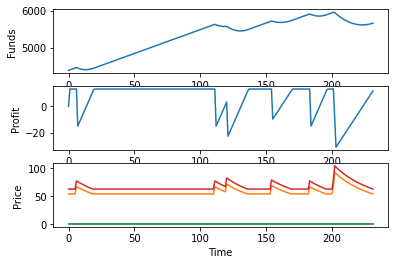

In [20]:
PORT = 8000

import requests

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


# Make a request to create a new simulation
def init():
    url = f'http://127.0.0.1:{PORT}/control/poll/create_from_example_sim4/{"T3"}'
    response = requests.post(url)
    if response.status_code == requests.codes.ok:
        jresponse = response.json()
        

# Make a request to run one step
def next_step():
    url = f'http://127.0.0.1:{PORT}/control/poll/run_one_step'
    response = requests.post(url)
    if response.status_code == requests.codes.ok:
        jresponse = response.json()

# Make a request to get the current funds available
def get_next_point():
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/inventory'
    response = requests.get(url)
    if response.status_code == requests.codes.ok:
        jresponse = response.json()
        return jresponse['funds_in_eur']
    else:
        return None

# List holding the x values
data_x = []
# List holding the y values
data_y = []
# List holding profit per hour
profit_per_hour = [0]
#List holding profit
profits = []
# Create sim
init()
#Initial funds
url = f'http://127.0.0.1:{PORT}/enterprise/poll/inventory'
response = requests.get(url)
jresponse = response.json()
initial_funds=jresponse['funds_in_eur']
#Dict holding sale prices
url = f'http://127.0.0.1:{PORT}/enterprise/poll/market_price'
response = requests.get(url)
jresponse = response.json()
market_prices=[[],[]]
break_even = [[],[]]


for x in range(0, 232):
    y = get_next_point() 
    next_step() # Do one step
    profits.append(y-initial_funds)
    
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/market_price'
    response = requests.get(url)
    jresponse = response.json()
   
    if jresponse[0]['item']['name']=='ProcMat1':
        market_prices[0].append(jresponse[0]['unit_price'])
        market_prices[1].append(jresponse[1]['unit_price'])
    else :
        market_prices[1].append(jresponse[0]['unit_price'])
        market_prices[0].append(jresponse[1]['unit_price'])
    
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/analytical_accounting_sim4'
    response = requests.get(url)
    jresponse = response.json()
    
    break_even[0].append(jresponse['ProcMat1'])
    break_even[1].append(jresponse['ProcMat2'])
    
    
    if x > 0 :
        profit_per_hour.append(y-data_y[-1]) #profit per hour
    
    data_x.append(x)  
    data_y.append(y) # funds
plt.subplot(3,1,1)
plt.plot(data_x, data_y)
plt.ylabel("Funds")
plt.xlabel("Time")
plt.subplot(3,1,2)
plt.plot(data_x, profit_per_hour)
plt.xlabel("Time")
plt.ylabel("Profit")
plt.subplot(3,1,3)
plt.plot(data_x, market_prices[0], data_x, break_even[0], data_x, market_prices[1], data_x, break_even[1])
plt.ylabel("Price")
plt.xlabel("Time")
plt.show()
    
    
    
    
    
   

# Bonus Task

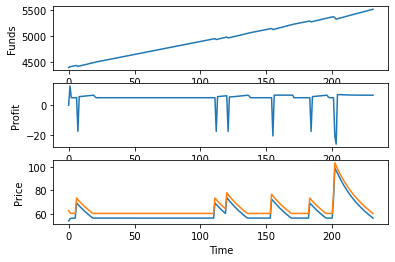

In [56]:
PORT = 8000

import requests

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


# Make a request to create a new simulation
def init():
    url = f'http://127.0.0.1:8000/control/poll/create_from_example_sim4/T3'
    response = requests.post(url)
    if response.status_code == requests.codes.ok:
        jresponse = response.json()
        

# Make a request to run one step
def next_step():
    url = f'http://127.0.0.1:{PORT}/control/poll/run_one_step'
    response = requests.post(url)
    if response.status_code == requests.codes.ok:
        jresponse = response.json()

# Make a request to get the current funds available
def get_next_point():
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/inventory'
    response = requests.get(url)
    if response.status_code == requests.codes.ok:
        jresponse = response.json()
        return jresponse['funds_in_eur']
    else:
        return None

# List holding the x values
data_x = []
# List holding the y values
data_y = []
# List holding profit per hour
profit_per_hour = [0]
#List holding profit
profits = []
# Create sim
init()
#Initial funds
url = f'http://127.0.0.1:{PORT}/enterprise/poll/inventory'
response = requests.get(url)
jresponse = response.json()
initial_funds=jresponse['funds_in_eur']
#Dict holding sale prices
url = f'http://127.0.0.1:{PORT}/enterprise/poll/market_price'
response = requests.get(url)
jresponse = response.json()
market_prices=[[],[]]
break_even = [[],[]]


for x in range(0, 232):
    y = get_next_point() 
    next_step() # Do one step
    profits.append(y-initial_funds)
    
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/market_price'
    response = requests.get(url)
    jresponse = response.json()
    
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/analytical_accounting_sim4'
    response = requests.get(url)
    jresponse = response.json()
    
    break_even[0].append(jresponse['ProcMat1'])
    break_even[1].append(jresponse['ProcMat2'])
    
    
    if x > 0 :
        profit_per_hour.append(y-data_y[-1]) #profit per hour
    
    data_x.append(x)  
    data_y.append(y) # funds
    
    url = f'http://127.0.0.1:{PORT}/enterprise/poll/set_market_sell_price_sim4'+'?ProcMat1_unit_price='+str(break_even[0][-1])+'&&ProcMat2_unit_price='+str(break_even[1][-1])
    data = {
        "ProcMat1_unit_price":break_even[0][-1],
        "ProcMat2_unit_price":break_even[1][-1]
    }
    requests.post(url, json=data)
    
plt.subplot(3,1,1)
plt.plot(data_x, data_y)
plt.ylabel("Funds")
plt.xlabel("Time")
plt.subplot(3,1,2)
plt.plot(data_x, profit_per_hour)
plt.xlabel("Time")
plt.ylabel("Profit")
plt.subplot(3,1,3)
plt.plot(data_x, break_even[0], data_x, break_even[1])
plt.ylabel("Price")
plt.xlabel("Time")
plt.show()

In [55]:

url = url = f'http://127.0.0.1:{PORT}/enterprise/poll/set_market_sell_price_sim4'+'?ProcMat1_unit_price='+str(break_even[0][-1])+'&&ProcMat2_unit_price='+str(break_even[1][-1])
data = {'ProcMat1_unit_price':2,'ProcMat2_unit_price':2}
requests.post(url, json = {'ProcMat1_unit_price':2,'ProcMat2_unit_price':2})

<Response [200]>